In [1]:
import os
import sys
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from fsrs_optimizer import rmse_matrix


module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from script import create_time_series


rust = False

if rust:
    sys.path.insert(0, os.path.abspath("/Users/jarrettye/Codes/anki/pylib"))
    sys.path.insert(0, os.path.abspath("/Users/jarrettye/Codes/anki/out/pylib"))

    from anki._backend import RustBackend

    backend = RustBackend()
    
    from anki.collection import FsrsItem, FsrsReview

In [2]:
from tqdm.auto import tqdm
tqdm.pandas()

def convert_to_items(df):  # -> list[FsrsItem]

    def accumulate(group):
        items = []
        for _, row in group.iterrows():
            t_history = [max(0, int(t)) for t in row["t_history"].split(",")] + [
                row["delta_t"]
            ]
            r_history = [int(t) for t in row["r_history"].split(",")] + [row["rating"]]
            items.append(
                FsrsItem(
                    reviews=[
                        FsrsReview(delta_t=int(x[0]), rating=int(x[1]))
                        for x in zip(t_history, r_history)
                    ]
                )
            )
        return items

    result_list = sum(
        df.sort_values(by=["card_id", "review_th"])
        .groupby("card_id")
        .apply(accumulate)
        .tolist(),
        [],
    )

    return result_list

In [3]:
file = Path("../dataset/1000.csv")
dataset = pd.read_csv(file)
dataset = create_time_series(dataset)
dataset.reset_index(drop=True, inplace=True)

  0%|          | 0/26 [00:00<?, ?it/s]

Pretrain finished!
dataset built
Universal Metric of new: 0.1162
Universal Metric of old: 0.1550
Pretrain finished!
dataset built
Universal Metric of new: 0.0712
Universal Metric of old: 0.1068
Pretrain finished!
dataset built
Universal Metric of new: 0.0697
Universal Metric of old: 0.0689
Pretrain finished!
dataset built
Universal Metric of new: 0.0603
Universal Metric of old: 0.0696
Pretrain finished!
dataset built
Universal Metric of new: 0.0616
Universal Metric of old: 0.0522
Pretrain finished!
dataset built
Universal Metric of new: 0.0541
Universal Metric of old: 0.0656
Pretrain finished!
dataset built
Universal Metric of new: 0.0570
Universal Metric of old: 0.0579
Pretrain finished!
dataset built
Universal Metric of new: 0.0569
Universal Metric of old: 0.0580
Pretrain finished!
dataset built
Universal Metric of new: 0.0515
Universal Metric of old: 0.0558
Pretrain finished!
dataset built
Universal Metric of new: 0.0522
Universal Metric of old: 0.0514
Pretrain finished!
dataset bui

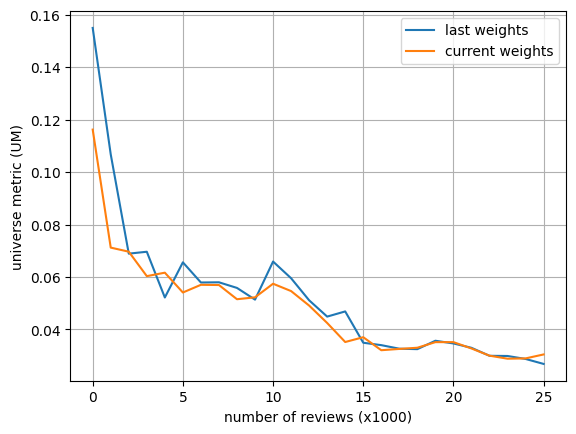

0.6538461538461539


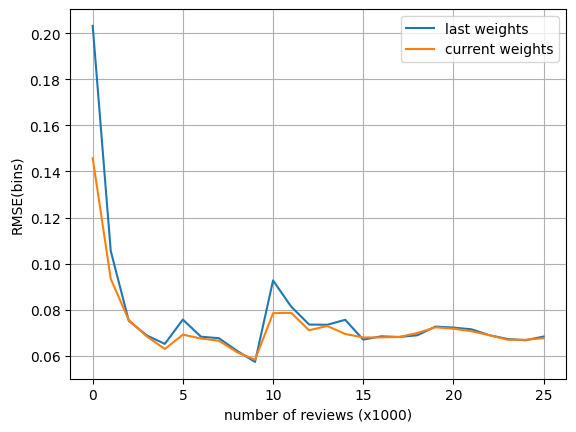

0.7692307692307693


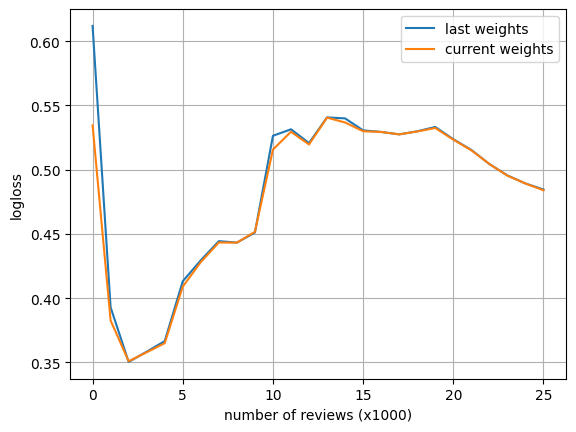

0.8461538461538461


In [4]:
from fsrs_optimizer import (
    Optimizer,
    Collection,
    Trainer,
    power_forgetting_curve,
    cross_comparison
)
import numpy as np
from sklearn.metrics import log_loss

optimizer = Optimizer()
optimizer.define_model()

def evaluate(weights):
    my_collection = Collection(weights)
    stabilities, difficulties = my_collection.batch_predict(train_set)
    stabilities = map(lambda x: round(x, 2), stabilities)
    difficulties = map(lambda x: round(x, 2), difficulties)
    train_set["stability"] = list(stabilities)
    train_set["difficulty"] = list(difficulties)
    train_set["p"] = power_forgetting_curve(train_set["delta_t"], train_set["stability"])
    logloss = log_loss(train_set["y"], train_set["p"])
    rmse_bins = rmse_matrix(train_set.copy())
    return logloss, rmse_bins

def evaluate_improvement(old, new):
    old_collection = Collection(old)
    s, _ = old_collection.batch_predict(train_set)
    old_p = power_forgetting_curve(train_set["delta_t"], s)
    new_collection = Collection(new)
    s, _ = new_collection.batch_predict(train_set)
    new_p = power_forgetting_curve(train_set["delta_t"], s)
    (um_new, um_old), fig = cross_comparison(pd.DataFrame({"R (old)": old_p, "R (new)": new_p, "y": train_set["y"]}), "old", "new")
    plt.close("all")
    return um_new, um_old
    


lr: float = 4e-2
n_epoch: int = 5
batch_size: int = 512
verbose: bool = False

last_weights = optimizer.init_w

um_last = []
um_cur = []

rmse_last = []
rmse_cur = []

logloss_last = []
logloss_cur = []

step = 1000
for max_index in tqdm(range(step, len(dataset), step)):
    train_set = dataset.loc[:max_index].copy()
    if rust:
        items = convert_to_items(train_set[train_set["i"] >= 2])
        weights = backend.compute_weights_from_items(items)
    else:
        optimizer.define_model()
        optimizer.init_w = last_weights.copy()
        optimizer.S0_dataset_group = (
            train_set[train_set["i"] == 2]
            # .groupby(by=["first_rating", "delta_t"], group_keys=False)
            .groupby(by=["r_history", "delta_t"], group_keys=False)
            .agg({"y": ["mean", "count"]})
            .reset_index()
        )
        _ = optimizer.pretrain(dataset=train_set, verbose=verbose)
        trainer = Trainer(
            train_set,
            train_set,
            optimizer.init_w,
            n_epoch=n_epoch,
            lr=lr,
            batch_size=batch_size,
        )
        weights = trainer.train(verbose=verbose)
    # tqdm.write(str(last_weights))
    # tqdm.write(str(weights))
    um_new, um_old = evaluate_improvement(last_weights, weights)
    um_last.append(um_old)
    um_cur.append(um_new)
    logloss, rmse = evaluate(last_weights)
    rmse_last.append(rmse)
    logloss_last.append(logloss)
    logloss, rmse = evaluate(weights)
    rmse_cur.append(rmse)
    logloss_cur.append(logloss)
    last_weights = weights

plt.plot(um_last, label="last weights")
plt.plot(um_cur, label="current weights")
plt.xlabel(f"number of reviews (x{step})")
plt.ylabel("universe metric (UM)")
plt.legend()
plt.grid()
plt.show()
print(sum((np.array(um_cur) < np.array(um_last))) / len(um_cur))

plt.plot(rmse_last, label="last weights")
plt.plot(rmse_cur, label="current weights")
plt.xlabel(f"number of reviews (x{step})")
plt.ylabel("RMSE(bins)")
plt.legend()
plt.grid()
plt.show()
print(sum((np.array(rmse_cur) < np.array(rmse_last))) / len(rmse_cur))

plt.plot(logloss_last, label="last weights")
plt.plot(logloss_cur, label="current weights")
plt.xlabel(f"number of reviews (x{step})")
plt.ylabel("logloss")
plt.legend()
plt.grid()
plt.show()
print(sum((np.array(logloss_cur) < np.array(logloss_last))) / len(logloss_cur))